<a href="https://colab.research.google.com/github/gabbypaola/DATA604/blob/main/G_Martinez_chap03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

## More than one State object

Here's the code from the previous chapter, with two changes:

1. I've added DocStrings that explain what each function does, and what parameters it takes.

2. I've added a parameter named `state` to the functions so they work with whatever `State` object we give them, instead of always using `bikeshare`.  That makes it possible to work with more than one `State` object.

In [2]:
def step(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)
        
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    state.olin -= 1
    state.wellesley += 1
    
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    state.wellesley -= 1
    state.olin += 1
    
def decorate_bikeshare():
    """Add a title and label the axes."""
    decorate(title='Olin-Wellesley Bikeshare',
             xlabel='Time step (min)', 
             ylabel='Number of bikes')

And here's `run_simulation`, which is a solution to the exercise at the end of the previous notebook.

In [3]:
def run_simulation(state, p1, p2, num_steps):
    """Simulate the given number of time steps.
    
    state: State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    num_steps: number of time steps
    """
    results = TimeSeries()    
    for i in range(num_steps):
        step(state, p1, p2)
        results[i] = state.olin
        
    plot(results, label='Olin')

In [4]:
#bikeshare = State(olin=10, wellesley=2)
#run_simulation(bikeshare, .4, .3, 10)

Now we can create more than one `State` object:

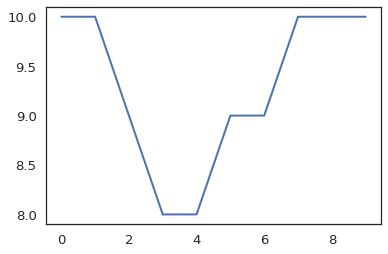

In [5]:
bikeshare1 = State(olin=10, wellesley=2)
run_simulation(bikeshare1, .4, .3, 10)

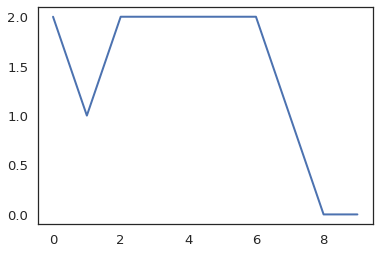

In [6]:
bikeshare2 = State(olin=2, wellesley=10)
run_simulation(bikeshare2, .4, .3, 10)

Whenever we call a function, we indicate which `State` object to work with:

In [7]:
bike_to_olin(bikeshare1)

In [8]:
bike_to_wellesley(bikeshare2)

And you can confirm that the different objects are getting updated independently:

In [9]:
bikeshare1

,values
olin,11
wellesley,1


In [10]:
bikeshare2

,values
olin,-1
wellesley,13


## Negative bikes

In the code we have so far, the number of bikes at one of the locations can go negative, and the number of bikes at the other location can exceed the actual number of bikes in the system.

If you run this simulation a few times, it happens often.

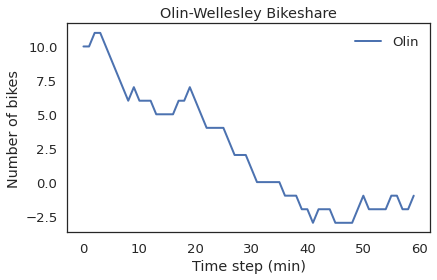

In [11]:
bikeshare = State(olin=10, wellesley=2) #defines state variable
run_simulation(bikeshare, 0.4, 0.2, 60) #state= bikeshare, p1=.4, p1=.2, step=60
decorate_bikeshare() #adds lables to plot output from run_simulation

We can fix this problem using the `return` statement to exit the function early if an update would cause negative bikes.

In [12]:
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    if state.olin == 0:
        return
    state.olin -= 1
    state.wellesley += 1
    
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    if state.wellesley == 0:
        return
    state.wellesley -= 1
    state.olin += 1

Now if you run the simulation again, it should behave.

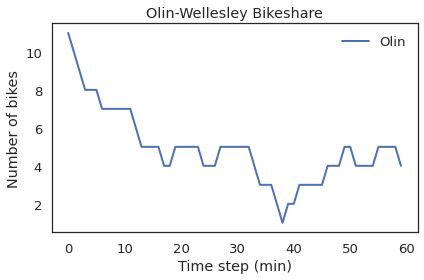

In [13]:
bikeshare = State(olin=10, wellesley=2)
run_simulation(bikeshare, 0.4, 0.2, 60)
decorate_bikeshare()

## Comparison operators

The `if` statements in the previous section used the comparison operator `==`.  The other comparison operators are listed in the book.

It is easy to confuse the comparison operator `==` with the assignment operator `=`.

Remember that `=` creates a variable or gives an existing variable a new value.

In [14]:
x = 5

Whereas `==` compares two values and returns `True` if they are equal.

In [15]:
x == 5

True

You can use `==` in an `if` statement.

In [16]:
if x == 5:
    print('yes, x is 5')

yes, x is 5


But if you use `=` in an `if` statement, you get an error.

In [17]:
# If you remove the # from the if statement and run it, you'll get
# SyntaxError: invalid syntax

#if x = 5:
#    print('yes, x is 5')

**Exercise:** Add an `else` clause to the `if` statement above, and print an appropriate message.

Replace the `==` operator with one or two of the other comparison operators, and confirm they do what you expect.

In [18]:
x = int(input('Please provide an integer: '))
if x > 5:
    print('yes, x is greater than 5')
else:
    print('no, x is not greater than five')

Please provide an integer: 4
no, x is not greater than five


## Metrics

Now that we have a working simulation, we'll use it to evaluate alternative designs and see how good or bad they are.  The metric we'll use is the number of customers who arrive and find no bikes available, which might indicate a design problem.

First we'll make a new `State` object that creates and initializes additional state variables to keep track of the metrics.

In [19]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)

Next we need versions of `bike_to_wellesley` and `bike_to_olin` that update the metrics.

In [20]:
 def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    if state.olin == 0: #if olin has no bikes then add to 
        state.olin_empty += 1 #counter for how many times olin has had no bikes -> negative customer experience
        return #don't execute below because it will cause a - bike count 
    state.olin -= 1 #otherwise, if olin != to 0, then move the bike from olin
    state.wellesley += 1 #move it to wellesley
    
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    if state.wellesley == 0: #if wellesley has no bikes then add to
        state.wellesley_empty += 1 #counter for how many times wellesley has had no bikes -> negative customer experience
        return
    state.wellesley -= 1 #otherwise, if wellesley != 0 then make the move from wellesley
    state.olin += 1 #to olin

Now when we run a simulation, it keeps track of unhappy customers.

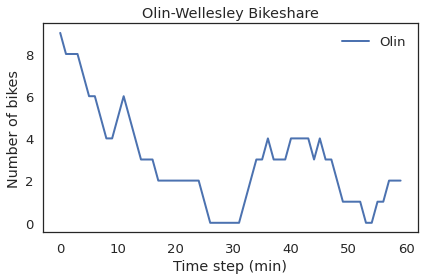

In [21]:
run_simulation(bikeshare, 0.4, 0.2, 60)
decorate_bikeshare()

After the simulation, we can print the number of unhappy customers at each location.

In [22]:
bikeshare.olin_empty

5

In [23]:
bikeshare.wellesley_empty

0

## Exercises

**Exercise:** As another metric, we might be interested in the time until the first customer arrives and doesn't find a bike.  To make that work, we have to add a "clock" to keep track of how many time steps have elapsed:

1. Create a new `State` object with an additional state variable, `clock`, initialized to 0. 

2. Write a modified version of `step` that adds one to the clock each time it is invoked.

Test your code by running the simulation and check the value of `clock` at the end.

In [24]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,
                  clock=0)

In [25]:
bikeshare.clock

0

In [26]:
# Solution goes here
def step(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)

    state.clock += 1

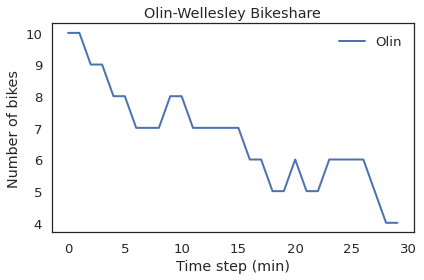

In [27]:
run_simulation(bikeshare, 0.4, 0.2, 30)
decorate_bikeshare()

In [28]:
# Solution goes here
bikeshare.clock
#not sure if correctly implemented, clock == step

30

**Exercise:** Continuing the previous exercise, let's record the time when the first customer arrives and doesn't find a bike.

1. Create a new `State` object with an additional state variable, `t_first_empty`, initialized to -1 as a special value to indicate that it has not been set. 

2. Write a modified version of `step` that checks whether`olin_empty` and `wellesley_empty` are 0.  If not, it should set `t_first_empty` to `clock` (but only if `t_first_empty` has not already been set).

Test your code by running the simulation and printing the values of `olin_empty`, `wellesley_empty`, and `t_first_empty` at the end.

In [66]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,
                  clock=0, t_first_empty=-1)

In [67]:
#Solution goes here: 
#Write a modified version of step that checks whether
#olin_empty and wellesley_empty are 0. If not, it should set t_first_empty 
#to clock (but only if t_first_empty has not already been set).

def step(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    state.clock += 1

    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)

    if state.t_first_empty != -1:
      return

    if (state.wellesley_empty + state.olin_empty) > 0:
      state.t_first_empty = state.clock

    

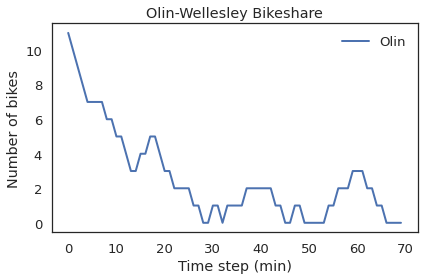

In [68]:
# Solution goes here
run_simulation(bikeshare, 0.4, 0.2, 70)
decorate_bikeshare()

In [69]:
bikeshare.olin_empty

5

In [70]:
bikeshare.wellesley_empty

0

In [71]:
bikeshare.t_first_empty

31

In [72]:
bikeshare

,values
olin,0
wellesley,12
olin_empty,5
wellesley_empty,0
clock,70
t_first_empty,31
